# Traffic on the I-94 Interstate highway.

<br>

The I-94 Interstate highway is an east–west Interstate Highway connecting the Great Lakes and northern Great Plains regions of the United States between Montana and Michigan.


A station located approximately midway between **Minneapolis and Saint Paul** recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).This means that the results of our analysis will be about the westbound traffic in the proximity of that station. 

In other words, we should avoid generalizing our results for the entire I-94 highway.

![Imgur](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Interstate_94_map.png/1920px-Interstate_94_map.png)

source:<a href=https://en.wikipedia.org/wiki/Interstate_94> https://en.wikipedia.org/wiki/Interstate_94 </a>

The aim is determine few indicators related with traffic like the weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows. 

In [1]:
%%html
<style>
table {float:left}
</style>

### Data dicctionary

| | |
|:---|:---|
| `holiday`| Categorical US National holidays plus regional holiday, Minnesota State Fair|
| `temp` | Numeric Average temp in kelvin|
|`rain_1h` | Numeric Amount in mm of rain that occurred in the hour|
|`snow_1h` |Numeric Amount in mm of snow that occurred in the hour |
| `clouds_all` |Numeric Percentage of cloud cover |
| `weather_main` |Categorical Short textual description of the current weather |
|`weather_description`| Categorical Longer textual description of the current weather|
|`date_time`| DateTime Hour of the data collected in local CST time|
|`traffic_volume` |Numeric Hourly I-94 ATR 301 reported westbound traffic volume|

###  Check the dataset

First of all I would like to see what kind of charset is our dataset file.

parameters:


      -i, --mime

    Causes the file command to output mime type strings rather than the more traditional human readable ones.  Thus it may say ‘text/plain; charset=us-ascii’ rather than “ASCII text”.

In [2]:
! file -k csv/Metro_Interstate_Traffic_Volume.csv

csv/Metro_Interstate_Traffic_Volume.csv: CSV text\012- , ASCII text


  -k, --keep-going

Don't stop at the first match, keep going.  Subsequent matches will be have the string ‘\012- ’ prepended.  (If you want a newline, see the -r option.)  The magic pattern with the highest strength (see the -l option)
comes first.

In [3]:
! file -i csv/Metro_Interstate_Traffic_Volume.csv

csv/Metro_Interstate_Traffic_Volume.csv: application/csv; charset=us-ascii


In [4]:
import chardet
with open("csv/Metro_Interstate_Traffic_Volume.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


### Loading data

In [5]:
import pandas as pd
traffic = pd.read_csv('csv/Metro_Interstate_Traffic_Volume.csv')

Now convert the value of the temperature that is in degrees Kelvin to degrees Celsius so that it is more comfortable to understand the temperatures during the study

In [6]:
# conversion from Fahrenheit to Celsius.
def K_to_C(K):
    return (K - 273.15)

In [7]:
traffic['temp'] = traffic['temp'].map(K_to_C).copy() 

In [8]:
traffic.head(5) 

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,15.13,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,16.21,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,16.43,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,16.98,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,17.99,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [9]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


The data seems to have its own type, be in good condition and there are no null values. 

We can start with the analysis.

## Analyzing Traffic Volume

Hourly Interstate 94 westbound traffic volume for MN DoT Station 301, approximately midway between Minneapolis and St Paul, MN.  Hourly weather features and holidays are included to see the impact on traffic volume.

This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

 Let's make 10 ranges with `bins = 10` of `traffic['traffic_volume']` with the data we have, the best way to visualize it is to use a histogram.

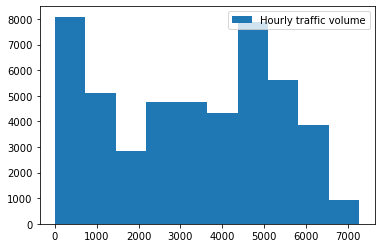

In [11]:
plt.hist(traffic['traffic_volume'], bins=10, label="Hourly traffic volume")
plt.legend()
plt.show()

The station ATR 301 in I-94 reported the Numeric Hourly westbound traffic, and we can see in the histogram the evolution of traffic during the daylight hours.

If we study the graph carefully we will see that:

- There are two moments in which the volume of traffic increases.


- Both situations the way in which the maximum point is reached is very abrupt.


- However the descent is not the same in the two maximum points.

In [12]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

- About 25% of the time, there were 1,193 cars or fewer passing the station each hour — **this probably occurs during the night**, or when a road is under construction.


- About 75% of the time, the traffic volume was four times as much (4,933 cars or more).

This possibility of night and day influencing traffic volume gives our analysis an interesting direction: 

- Comparing daytime data with nighttime data.

* * *

We will start by dividing the data set into two parts:

 - **Daytime data**: hours from 7 a.m. to 7 p.m. (12 hours).
 
 
 - **Nighttime data**: hours from 7 p.m. to 7 a.m. (12 hours).
 
Although this is not a perfect criterion for distinguishing between night and daytime hours, it is a good starting point.

For this we are going to convert the `date_time` column that is **text type** to the **datetime** data type.

In [13]:
traffic['date_time'] = pd.to_datetime(traffic['date_time']).copy() 
traffic['date_time'] # text to datetime

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
48199   2018-09-30 19:00:00
48200   2018-09-30 20:00:00
48201   2018-09-30 21:00:00
48202   2018-09-30 22:00:00
48203   2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: datetime64[ns]

Once the conversion is done to the type of data we need now we can easily extract the hours.

In [14]:
traffic['date_time'].dt.hour.unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  8,  7])

With the `datetime.hour` method used as a Boolean filter and assigned to a variable called `alles_bool`

In [15]:
alles_bool = traffic['date_time'].dt.hour
alles_bool

0         9
1        10
2        11
3        12
4        13
         ..
48199    19
48200    20
48201    21
48202    22
48203    23
Name: date_time, Length: 48204, dtype: int64

These are the values of the hours I will work with.

In [16]:
horas_alles = traffic.loc[alles_bool,'date_time'].dt.hour
horas_alles.unique()

array([18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11,
       12, 13, 14, 15, 17, 16])

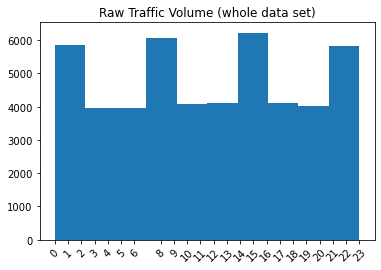

In [17]:
plt.hist(horas_alles)
plt.title('Raw Traffic Volume (whole data set)')
plt.xticks(ticks=horas_alles.unique(),
           labels=horas_alles.unique(),
           rotation=45)
plt.show()

Histograms shows accumulation or trend, variability or dispersion and form of the distribution.

Therefore we can see the distribution of traffic volume in a day, we see three time slots where the movement of vehicles is greater:

- **Morning from 07:00 to 09:00 AM**

- **Noon from 14:00 to 16:00 PM**

- **Night from 21:00 to 02:00 AM**.

We continue with the idea of separating day and night.

## Day

We set the interval that corresponds to the hours of the day.

Establish the values that are greater than or equal to 7 and values that are less than or equal to 19. There we will have the interval that corresponds to the daytime hours.

In [18]:
day_bool = (traffic['date_time'].dt.hour >=7) & (traffic['date_time'].dt.hour <=19)

In [19]:
horas_daytime = traffic.loc[day_bool,'date_time'].dt.hour
horas_daytime.unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  8,  7])

In [20]:
horas_daytime

0         9
1        10
2        11
3        12
4        13
         ..
48195    15
48196    16
48197    17
48198    18
48199    19
Name: date_time, Length: 25838, dtype: int64

In [21]:
traffic_daytime = traffic[day_bool].copy()
traffic_daytime

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,15.13,0.00,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,16.21,0.00,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,16.43,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,16.98,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,17.99,0.00,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48195,None,10.69,0.00,0.0,75,Drizzle,light intensity drizzle,2018-09-30 15:00:00,4302
48196,None,11.23,0.00,0.0,75,Rain,light rain,2018-09-30 16:00:00,4283
48197,None,11.64,0.00,0.0,75,Clouds,broken clouds,2018-09-30 17:00:00,4132
48198,None,11.05,0.25,0.0,75,Rain,light rain,2018-09-30 18:00:00,3947


## Night

We do the same operation with the hours that correspond to those of the night.

In [22]:
night_bool = (traffic['date_time'].dt.hour >=19) | (traffic['date_time'].dt.hour <=7)

In [23]:
horas_nighttime = traffic.loc[night_bool,'date_time'].dt.hour
horas_nighttime.unique()

array([19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7])

In [24]:
#traffic_night = traffic[night_bool].copy()
traffic_night = traffic[night_bool].copy()
traffic_night

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
10,None,17.82,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539
11,None,16.23,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784
12,None,15.46,0.0,0.0,1,Clear,sky is clear,2012-10-02 21:00:00,2361
13,None,14.01,0.0,0.0,1,Clear,sky is clear,2012-10-02 22:00:00,1529
14,None,12.30,0.0,0.0,1,Clear,sky is clear,2012-10-02 23:00:00,963
...,...,...,...,...,...,...,...,...,...
48199,None,10.30,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,9.61,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,9.58,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,8.94,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


Now we're going to compare the distribution on traffic volume at night and during day.

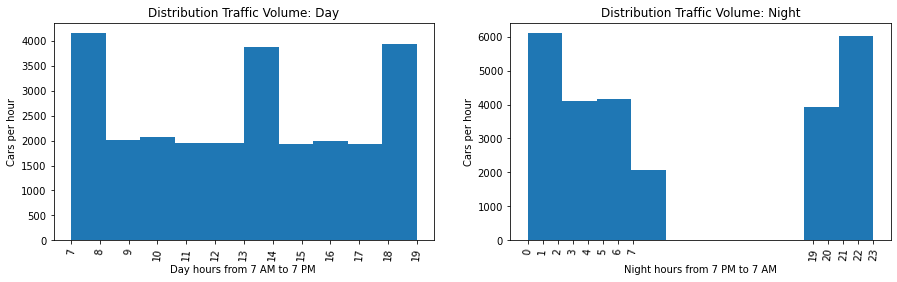

In [25]:
plt.figure(figsize = (15,4))

plt.subplot(1,2,1)

plt.hist(horas_daytime)
plt.xlabel('Day hours from 7 AM to 7 PM ')
plt.ylabel('Cars per hour')
plt.title('Distribution Traffic Volume: Day')
plt.xticks(ticks=horas_daytime.unique(),
           labels= horas_daytime.unique(),
           rotation=85)


plt.subplot(1,2,2)

# bins = 'auto', esto se me habia pasado y la grafica que me daba no tenía sentido!

plt.hist( horas_nighttime)
plt.xlabel('Night hours from 7 PM to 7 AM')
plt.ylabel('Cars per hour')
plt.title('Distribution Traffic Volume: Night')
plt.xticks(ticks=horas_nighttime.unique(),
           labels=horas_nighttime.unique(),
           rotation=85)
plt.show()

In [26]:
traffic_daytime.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,25838.000000,25838.000000,25838.000000,25838.000000,25838.000000
mean,9.197796,0.502320,0.000234,53.040135,4649.292360
std,13.302562,61.167614,0.008511,37.590946,1202.321987
min,-273.150000,0.000000,0.000000,0.000000,0.000000
25%,-0.430000,0.000000,0.000000,5.000000,4021.000000
50%,10.717000,0.000000,0.000000,75.000000,4736.000000
75%,20.460000,0.000000,0.000000,90.000000,5458.000000
max,36.920000,9831.300000,0.510000,100.000000,7280.000000


In [27]:
traffic_night.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,26406.000000,26406.000000,26406.000000,26406.000000,26406.000000
mean,6.891662,0.142964,0.000181,46.043021,2018.015375
std,13.312483,1.131005,0.007148,39.995392,1713.201969
min,-273.150000,0.000000,0.000000,0.000000,0.000000
25%,-1.550000,0.000000,0.000000,1.000000,581.000000
50%,8.130000,0.000000,0.000000,40.000000,1485.000000
75%,17.400000,0.000000,0.000000,90.000000,2934.000000
max,34.530000,55.630000,0.510000,100.000000,7260.000000


## Summary from both histograms:

We can observe in greater detail, the time slots mentioned above, 

- From 7 am traffic begins to increase until 8 am to reduce the volume in half until noon where it increases again from 13 until 14 pm to reduce the volume again and again increase traffic to coincide with the end of the working day.


- The volume of vehicles at night is much lower than day, although there are occasional moments when the return home causes the volume to increase significantly for a short period of time.  





The rest of the time the volume is much lower.

* * * 

### Our goal is to find indicators of heavy traffic

So we decided to only **focus on the daytime** data moving forward.

One of the possible indicators of heavy traffic is time periods when is more people on the road, so there are certain months, days, or certain time of the day where this happens.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

#### - Month

#### - Day of the week

#### - Time of day

The fastest way to get the average traffic volume for each month is by using the `DataFrame.groupby()` method.

## Monthly

in the same way that we extracted the hours we proceed to extract the months.

In [28]:
traffic_daytime['month_day'] = traffic_daytime['date_time'].dt.month
by_month_day = traffic_daytime.groupby('month_day').mean()
by_month_day['traffic_volume']

month_day
1     4385.217310
2     4593.187798
3     4761.529676
4     4771.232816
5     4788.966639
6     4791.087488
7     4502.628360
8     4818.434690
9     4755.709916
10    4809.481678
11    4588.910486
12    4276.567081
Name: traffic_volume, dtype: float64

This is the result of grouping the average traffic for each of the months.


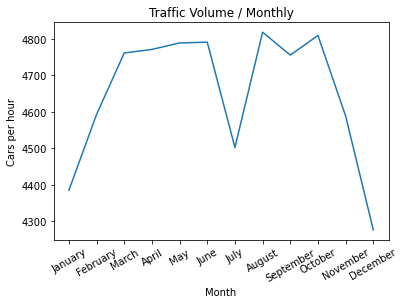

In [29]:
plt.plot(by_month_day['traffic_volume'])
plt.xticks(ticks=[1, 2, 3, 4, 5, 6,7,8,9,10,11,12],
           labels=['January', 'February', 'March','April',
                   'May','June', 'July','August','September', 'October', 'November','December'],
           rotation=30)

plt.xlabel('Month')
plt.ylabel('Cars per hour')
plt.title('Traffic Volume / Monthly')

plt.show()

This is how these values are represented in a graph.

### note:

As we had previously mentioned, it seems that the volume of traffic is more focused on certain months of the year, except for the coldest months and the month of July that seems to not lead to any important summer site by the traffic volume, which seems to be the month most Americans choose as their vacation month.

## Day of the week.

To get the traffic volume averages for each day of the week, we'll need to get the day as we did before on hours and month.

In [30]:
traffic_daytime['dayofweek'] = traffic_daytime['date_time'].dt.dayofweek
by_dayofweek = traffic_daytime.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

dayofweek
0    4746.208029
1    5036.062431
2    5141.231163
3    5163.688063
4    5161.533588
5    3884.065668
6    3410.368091
Name: traffic_volume, dtype: float64

This is the average traffic per day of the week.

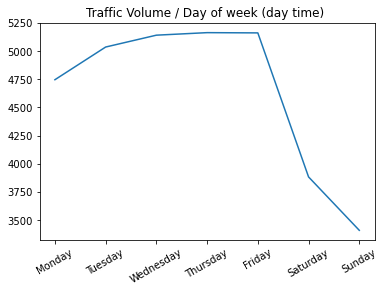

In [31]:
plt.plot(by_dayofweek['traffic_volume'])
plt.title('Traffic Volume / Day of week (day time) ')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=[ 'Monday', 'Tuesday',
                                                'Wednesday', 'Thursday', 
                                                'Friday', 'Saturday','Sunday'],
           rotation=30) 
plt.show()

### note:

We found that the traffic volume is significantly heavier on business days compared to the weekends.

We'll now generate a line plot for the time of day. 

The weekends, however, will drag down the average values, so we're going to look at the averages separately.

To do that, we'll start by **splitting the data based on the day type**: 

**- business day or weekend.**

Below, we show you how to split the dataset so you can focus on plotting the graphs. While your variable names may vary, the logic of the code should be the same.

In [32]:
# Splitting Data

traffic_daytime['hour_day'] = traffic_daytime['date_time'].dt.hour           # Filtering days

bussiness_days = traffic_daytime.copy()[traffic_daytime['dayofweek'] <= 4]   # 4 <= Monday to Friday
weekend = traffic_daytime.copy()[traffic_daytime['dayofweek'] >= 5]          # 5 >= Saturday Sunday

by_hour_business = bussiness_days.groupby('hour_day').mean()                       
by_hour_weekend = weekend.groupby('hour_day').mean()


print("by_hour_business: {}".format(by_hour_business['traffic_volume']))

print("\n")

print("by_hour_weekend: {}".format(by_hour_weekend['traffic_volume']))



by_hour_business: hour_day
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
19    3298.340426
Name: traffic_volume, dtype: float64


by_hour_weekend: hour_day
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
19    3220.234120
Name: traffic_volume, dtype: float64


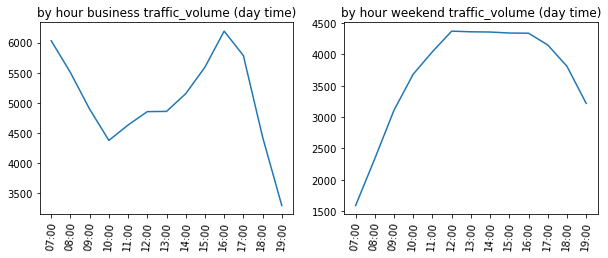

In [33]:
plt.figure(figsize=(10, 12))

plt.ylim([0, 24])
plt.subplot(3, 2, 1)
plt.title('by hour business traffic_volume (day time)')
plt.plot(by_hour_business['traffic_volume'])
plt.xticks(ticks=[7,8,9,10,11,12,13,14,15,16,17,18,19,],
           labels=['07:00','08:00','09:00','10:00','11:00',
                   '12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00'],
           rotation=85)


plt.subplot(3, 2, 2)
plt.title('by hour weekend traffic_volume (day time)')
plt.plot(by_hour_weekend['traffic_volume'])
plt.xticks(ticks=[7,8,9,10,11,12,13,14,15,16,17,18,19,],
           labels=['07:00','08:00','09:00','10:00','11:00',
                   '12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00'],
           rotation=85)

plt.show()

### note:

- According to what has been seen so far the Road use appears to have a direct relationship with weekday work schedules and therefore the increased frequency of vehicles per hour passing by and the volumen may cause some kind of jam.


- Hoewer the Weekend use is much more progressive and there does not seem to be anything related to work schedules that sets the tempo of use, and the volume of vehicles is also lower compared with the weekday work.

In [34]:
traffic_daytime.corr()['traffic_volume'].sort_values(ascending = False)

traffic_volume    1.000000
temp              0.118084
rain_1h           0.004020
snow_1h           0.003768
hour_day         -0.007369
month_day        -0.017397
clouds_all       -0.033410
dayofweek        -0.371023
Name: traffic_volume, dtype: float64

There is a slight positive correlation between temperature and traffic volume 

also noticed that there are more significative negative correlation on traffic volume (decreases) depending on whatever the day of the week, as we had seen before.

Let's visualize it.

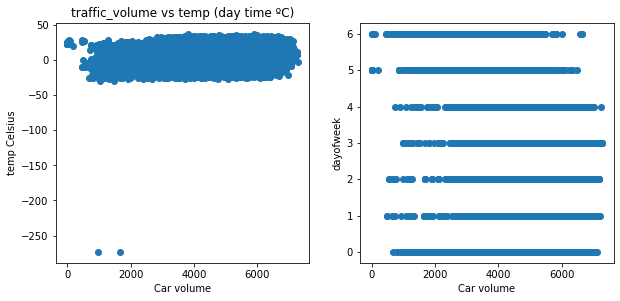

In [35]:
plt.figure(figsize=(10, 15))
plt.ylim([0, 24])

plt.subplot(3, 2, 1)

plt.xlabel('Car volume')
plt.ylabel('temp Celsius')

plt.title('traffic_volume vs temp (day time ºC)')
plt.scatter(traffic_daytime['traffic_volume'],traffic_daytime['temp'])


plt.subplot(3, 2, 2)

plt.xlabel('Car volume')
plt.ylabel('dayofweek')
plt.scatter(traffic_daytime['traffic_volume'],traffic_daytime['dayofweek'])

plt.show()

### note:

There are outlayers, but in this exercise we will leave it here and in a later version we will work with them.

as the correlation indicated, temperature is not an important factor in traffic.

However we can see the day of the week is one of the parameters that most affects traffic, even so we see that it does not have an extreme relevance.

* * *

### Weather indicators: 

To see if we can find more useful data, we'll look next at the categorical weather-related columns: 

### `weather_main ` and ` weather_description`

We're going to calculate the average traffic volume associated with each unique value in these two columns. 

This is the middle category of how the sky is in every day.

In [36]:
by_weather_main_day = traffic_daytime.groupby('weather_main').mean()  # Columna categorica: Nubado... claro 
by_weather_description_day = traffic_daytime.groupby('weather_description').mean()

In [37]:
by_weather_main_day

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month_day,dayofweek,hour_day
weather_main,,,,,,,,
Clear,10.734100,0.000000,0.000000,1.676447,4661.666879,6.492107,3.143518,12.958539
Clouds,9.821967,0.000000,0.000000,62.700890,4746.375927,6.391820,2.999894,13.386734
Drizzle,11.282372,0.168234,0.000000,84.781609,4712.699060,7.074190,2.921630,12.825496
Fog,4.228271,0.157739,0.001356,66.281915,4298.933511,6.625000,2.827128,10.648936
Haze,2.576381,0.060947,0.000000,63.916667,4545.434932,5.873288,2.748858,12.780822
Mist,6.192164,0.249371,0.000778,75.518370,4530.901782,6.731175,2.903601,11.527828
Rain,14.022515,3.690371,0.000268,75.771069,4686.953503,6.755247,2.905392,13.167904
Smoke,19.380000,0.810769,0.000000,49.307692,4447.307692,6.846154,2.230769,13.615385
Snow,-5.097312,0.013233,0.001648,80.945478,4295.594612,6.375241,2.756895,12.614496


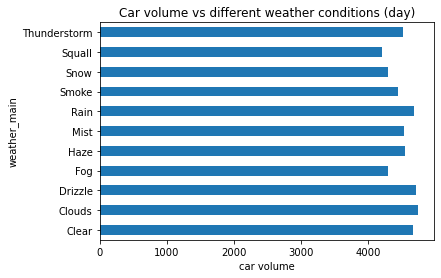

In [38]:
by_weather_main_day['traffic_volume'].plot.barh()
plt.title('Car volume vs different weather conditions (day)')
plt.xlabel('car volume')
plt.show()

It seems that the atmospheric weather conditions are not directly responsible for a reduction in traffic

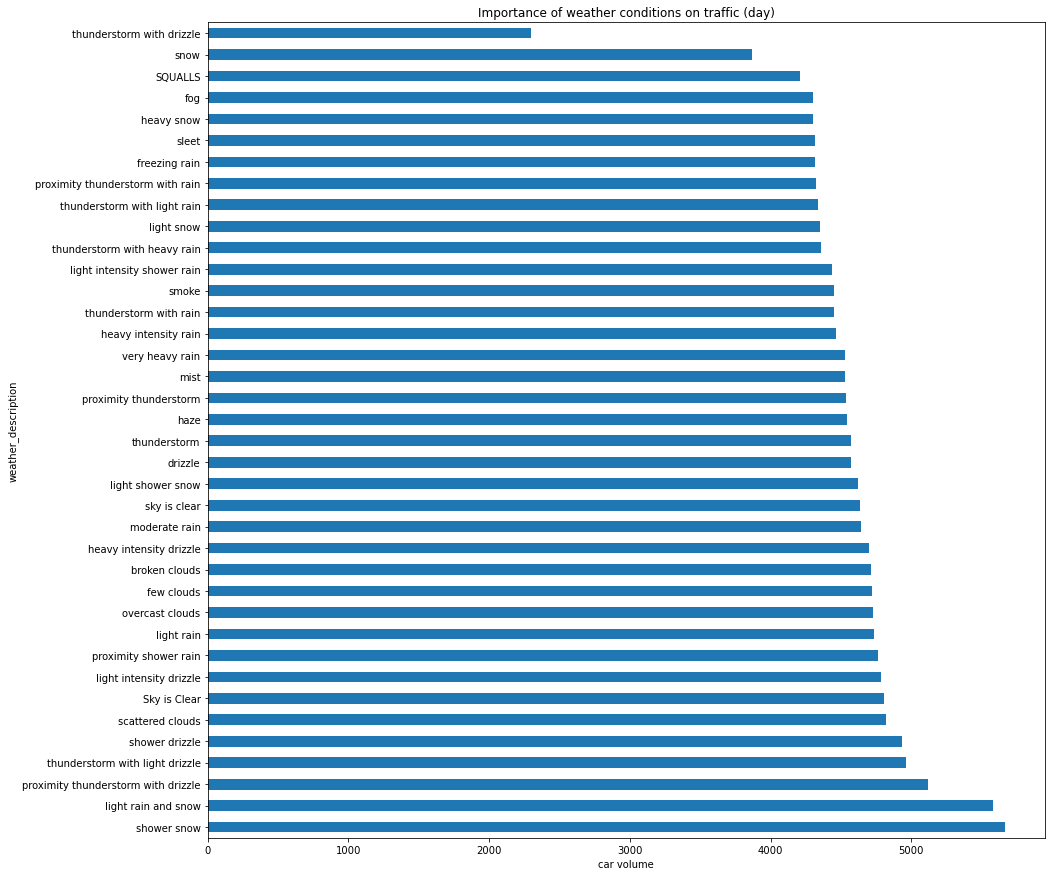

In [39]:
plt.figure(figsize=(15,15))

A = by_weather_description_day['traffic_volume'].sort_values(ascending = False)
A.plot.barh()
plt.title('Importance of weather conditions on traffic (day)')
plt.xlabel('car volume')
plt.show()

The only two situations in which we can see a half reduction in traffic is when thunderstorm with drizzle appears.


In other situations there is a reduction but it is very small.










## Summary:

### Time indicators for the day:


| **Most Traffic** | **Frequency Month**    | **Laboral hours** | **Weekend hours** | 
| :---         |  :---              | :---           | :---          | 
| **Day time**     | Feb-May / Aug-Oct  | 07:00-09:00   | 11:00-15:00    | 
| **Night time**   | May-June / Jul-Aug | 04:00-07:00   | 05:00-07:00    | 

 - On business days, the rush hours are around 7-8 AM and 18-23 PM, heavier on business days compared to the weekends.

- The traffic is heavier during warm months (March–October) compared to cold months (November–February).


- when we have studied the possible causes of correlation (negative correlation ) we have seen that the parameter that can be influential in the decrease in traffic is the arrival of the weekend.

### Weather indicators:

- When shower snow, light rain and snow proximity thunderstorm with drizzle are over the highway, the volume of cars is reduced with a tendency towards 5000 vehicles per hour.


- The most influential weather event on the freeway is a drizzle storm, which causes the freeway usage to drop to below 2500 vehicles per hour.


- Possibly the fact that the volume of traffic does not decrease with these meteorological phenomena may be due to the fact that it is a communication route that is used by workers and somehow they are forced to take the car in quite adverse weather conditions.

### Conclusions:

As a final conclusion we can not forget that being a station that only records traffic in a westerly directionm, the results of our analysis are strongly biased, but we could say that it is a road strong linked to the schedules of working people, and that is precisely why the meteorological phenomena do not have a transcendence in the volume of traffic however this is clearly affected by the weekend or holiday period.